##Downloading data from Kaggle

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")

In [ ]:
# Setting up train and testing paths
training_path = 'brain-tumor-classification-mri/Training'
test_path = 'brain-tumor-classification-mri/Testing'

## Importing libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix


##Data visualisation

In [ ]:
# Plotting the images for each class in training and test dataset
def plot_images(path, title):
  list_path=os.listdir(path)
  plt.figure(figsize=(10,6))
  plt.suptitle(title)
  for i in range(1,10):
    plt.subplot(3,3,i)
    img=plt.imread(os.path.join(path,list_path[i]))
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()

In [ ]:
# Checking class name for training dataset, it is same for test data as well
class_name = os.listdir(training_path)
class_name

['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor']

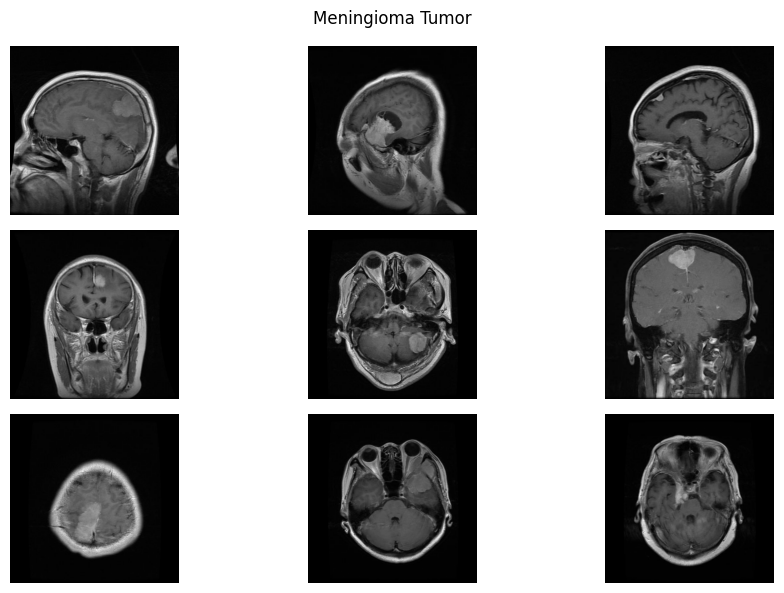

In [ ]:
# Plotting image for Meningioma tumor
plot_images(training_path+'/'+class_name[0], 'Meningioma Tumor')

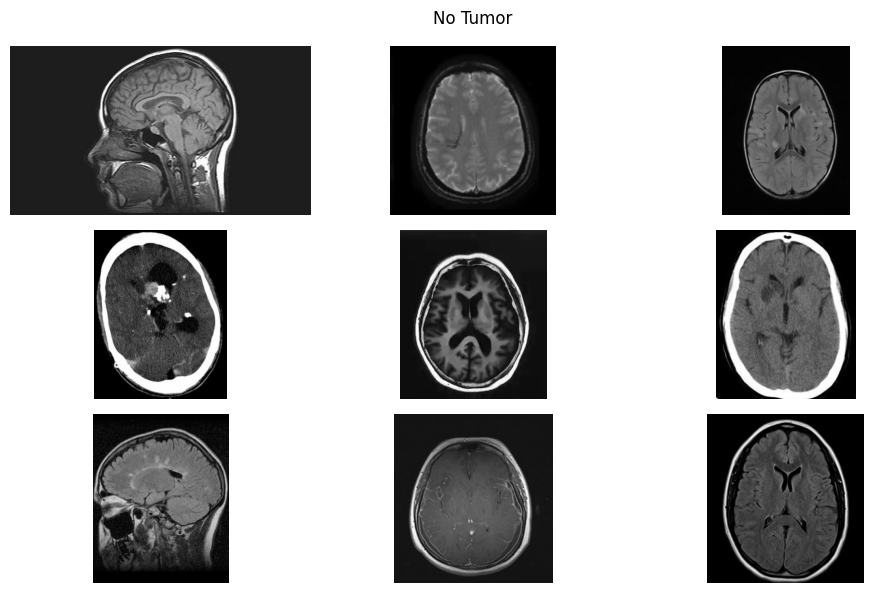

In [ ]:
plot_images(training_path+'/'+class_name[1], 'No Tumor')

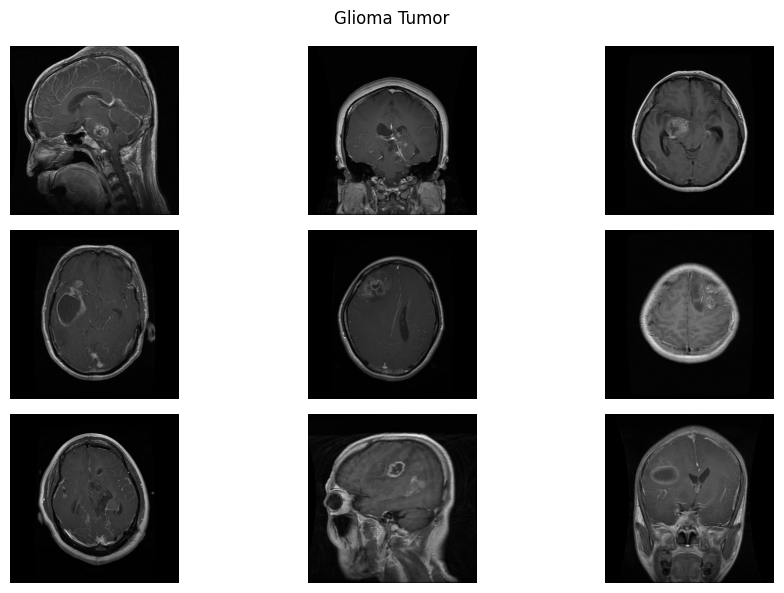

In [ ]:
plot_images(training_path+'/'+class_name[2], 'Glioma Tumor')

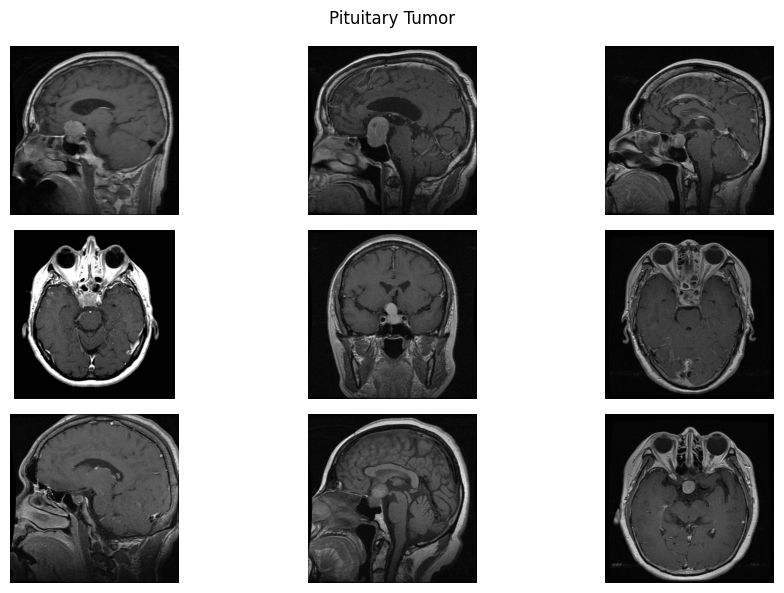

In [ ]:
plot_images(training_path+'/'+class_name[3], 'Pituitary Tumor')

##Pre-processing of data

In [ ]:
# Setting image size to resize all the image to specific size, it will help during training our model with these training dataset
image_size = 80

In [ ]:
# Loading images from Train and test directories
def get_data(path, class_name, image_size):
  X = []
  y = []
  for i in class_name:
      folderPath = os.path.join(path,i)
      for j in os.listdir(folderPath):
          img = cv2.imread(os.path.join(folderPath,j))
          img = cv2.resize(img,(image_size, image_size))
          X.append(img)
          y.append(i)
  return X, y

In [ ]:
# Loading training images and labels from directory
X_train, y_train = get_data(training_path, class_name, image_size)
# Loading test images and labels from directory
X_test, y_test = get_data(test_path, class_name, image_size)

In [ ]:
print("Length of X_train: "+ str(len(X_train)))
print("Length of X_test "+ str(len(X_test)))

Length of X_train: 2870
Length of X_test 394


In [ ]:
# Concatenating both the training and test dataset such that we can suffle the data evenly among these datasets
X_train = X_train + X_test
y_train = y_train + y_test

In [ ]:
# Converting list to numpy array such that it will be easy for processing and model training
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# Shuffling the dataset for better generalisation
X_train, y_train = shuffle(X_train,y_train, random_state=51)

In [ ]:
# Spliting the training and testing dataset into 80:20 ratio
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=51)

In [ ]:
# converting the decimal target values to categorical values as categorical values help is faster processing and decreasses the computational cost of the model training
def labels_to_categorical_values(y, class_name):
  y_new = []
  for i in y:
      y_new.append(class_name.index(i))
  y = y_new
  y = tf.keras.utils.to_categorical(y)
  return y

In [ ]:
# Converting train labels to categorical values
y_train = labels_to_categorical_values(y_train, class_name)
# Converting test labels to categorical values
y_test = labels_to_categorical_values(y_test, class_name)

##Model 1: Mobile net

In [ ]:
'''Using the pre-trained weights from imagenet to mobilenet architecture, adding a pre-trained weight
helps to learn the features of the model quickly and also helps in generalisation of model,
thereby preventing the chances of overfitting'''
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size,image_size, 3))

for layer in mobilenet.layers:
    layer.trainable = False

# Global average pooling layer and dense layer with 4 neurons are used as the output layers at the end of mobilenet architecture
x = GlobalAveragePooling2D()(mobilenet.output)
out = Dense(4, activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=out)

In [ ]:
# Printing model summary
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 40, 40, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 40, 40, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 40, 40, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 40, 40, 32)       128       
 ation)                                                   

In [ ]:
# Adding callbacks for earlystopping while monitoring validation loss
callbacks=[EarlyStopping(monitor='val_loss',patience=10)]
# Setting hyperparameters of the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the model for 10 epochs and 32 batch size, spliting the training data into 90:10 ratio for validation dataset
history=model.fit(X_train, y_train,validation_split=0.1,epochs=10, batch_size=32)#callbacks=callbacks

Epoch 1/10
59/59 [==============================] - 22s 281ms/step - loss: 0.4482 - accuracy: 0.8185 - val_loss: 0.6787 - val_accuracy: 0.7512
Epoch 2/10
59/59 [==============================] - 12s 209ms/step - loss: 0.4017 - accuracy: 0.8531 - val_loss: 0.6218 - val_accuracy: 0.7512
Epoch 3/10
59/59 [==============================] - 14s 232ms/step - loss: 0.3801 - accuracy: 0.8616 - val_loss: 0.6173 - val_accuracy: 0.7703
Epoch 4/10
59/59 [==============================] - 15s 249ms/step - loss: 0.3546 - accuracy: 0.8670 - val_loss: 0.6008 - val_accuracy: 0.7751
Epoch 5/10
59/59 [==============================] - 17s 292ms/step - loss: 0.3399 - accuracy: 0.8797 - val_loss: 0.6168 - val_accuracy: 0.7656
Epoch 6/10
59/59 [==============================] - 14s 234ms/step - loss: 0.3307 - accuracy: 0.8813 - val_loss: 0.5933 - val_accuracy: 0.7703
Epoch 7/10
59/59 [==============================] - 15s 257ms/step - loss: 0.3127 - accuracy: 0.8925 - val_loss: 0.5781 - val_accuracy: 0.7799

In [ ]:
# Plot history of the training to check what happens per epoch
def plot_history(train, validation, title):
  plt.plot(train, color = 'r')
  plt.plot(validation, color = 'b')
  plt.xlabel("Epochs")
  plt.ylabel(title)
  plt.title(title+" of training and validation set per epoch")
  plt.gca().legend(('Train','Val'))
  plt.show()

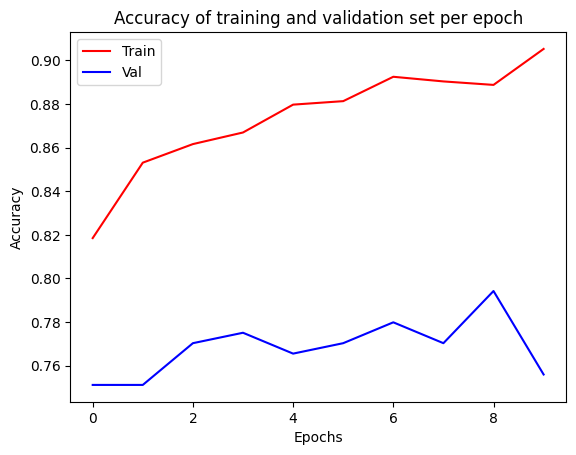

In [ ]:
# Plotting training and validation accuracy
plot_history(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")

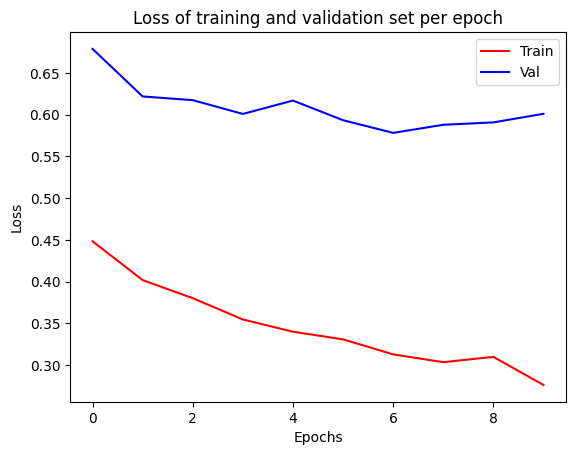

In [ ]:
# Plotting training and validation loss
plot_history(history.history['loss'], history.history['val_loss'], "Loss")

In [ ]:
# Evaluating the model
pred = model.predict(X_test)
# Conversion to pred and y_test to decimal value from categorical value as classification report is generated based on decimal value comparision
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

print(classification_report(y_test_new,pred))

17/17 [==============================] - 3s 132ms/step
              precision    recall  f1-score   support

           0       0.70      0.60      0.64       147
           1       0.87      0.69      0.77        94
           2       0.64      0.80      0.71       133
           3       0.87      0.91      0.89       149

    accuracy                           0.76       523
   macro avg       0.77      0.75      0.75       523
weighted avg       0.76      0.76      0.75       523



##Model 2:Inception net

In [ ]:
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size, 3))

for layer in inceptionv3.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(inceptionv3.output)
out = Dense(4, activation='softmax')(x)

inception_net_model = Model(inputs=inceptionv3.input, outputs=out)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
callbacks=[EarlyStopping(monitor='val_loss',patience=10)]

inception_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
inception_net_history=inception_net_model.fit(X_train, y_train, validation_split = 0.1, batch_size = 32, verbose=1, epochs = 10, callbacks=callbacks)

Epoch 1/10
59/59 [==============================] - 32s 464ms/step - loss: 8.9348 - accuracy: 0.4332 - val_loss: 6.8163 - val_accuracy: 0.4258
Epoch 2/10
59/59 [==============================] - 21s 357ms/step - loss: 4.5789 - accuracy: 0.5455 - val_loss: 4.0925 - val_accuracy: 0.5837
Epoch 3/10
59/59 [==============================] - 19s 316ms/step - loss: 3.5136 - accuracy: 0.6131 - val_loss: 4.1850 - val_accuracy: 0.6029
Epoch 4/10
59/59 [==============================] - 20s 338ms/step - loss: 3.0345 - accuracy: 0.6184 - val_loss: 3.8152 - val_accuracy: 0.5502
Epoch 5/10
59/59 [==============================] - 18s 302ms/step - loss: 2.5121 - accuracy: 0.6466 - val_loss: 2.4841 - val_accuracy: 0.6316
Epoch 6/10
59/59 [==============================] - 20s 338ms/step - loss: 1.8421 - accuracy: 0.6860 - val_loss: 2.8618 - val_accuracy: 0.6603
Epoch 7/10
59/59 [==============================] - 18s 301ms/step - loss: 1.8956 - accuracy: 0.6951 - val_loss: 3.0100 - val_accuracy: 0.5885

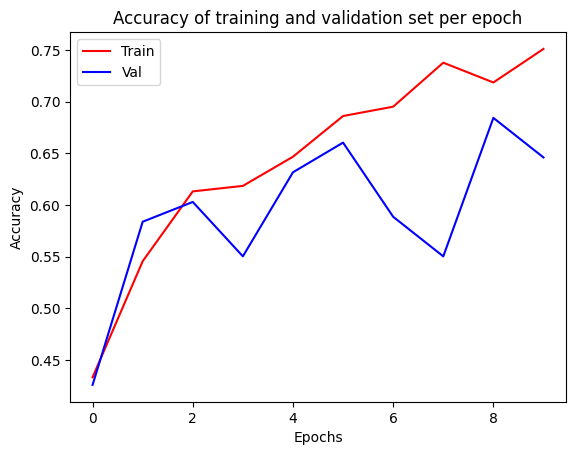

In [ ]:
# Plotting training and validation accuracy
plot_history(inception_net_history.history['accuracy'], inception_net_history.history['val_accuracy'], "Accuracy")

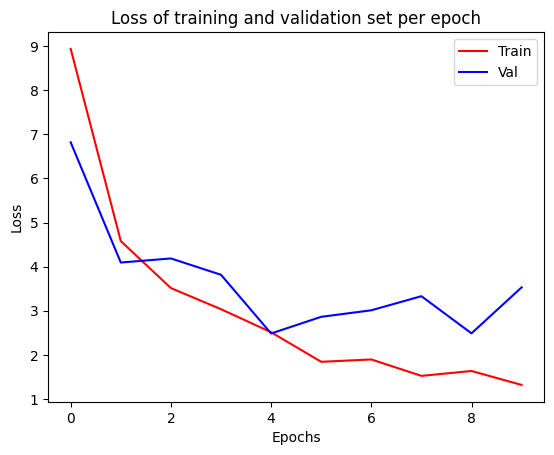

In [ ]:
# Plotting training and validation loss
plot_history(inception_net_history.history['loss'], inception_net_history.history['val_loss'], "Loss")

In [ ]:
# Evaluating the model
pred = inception_net_model.predict(X_test)
# Conversion to pred and y_test to decimal value from categorical value as classification report is generated based on decimal value comparision
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

print(classification_report(y_test_new,pred))

17/17 [==============================] - 7s 325ms/step
              precision    recall  f1-score   support

           0       0.66      0.50      0.57       147
           1       0.50      0.78      0.61        94
           2       0.77      0.40      0.52       133
           3       0.65      0.87      0.74       149

    accuracy                           0.63       523
   macro avg       0.65      0.63      0.61       523
weighted avg       0.66      0.63      0.61       523

